# Demo Notebook with simulated RGCs data and simple CNN

In [5]:
%config Completer.use_jedi = False

In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2 
%load_ext memory_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import neuralpredictors as neur
from neuralpredictors.data.datasets import StaticImageSet, FileTreeDataset
import MEI
import matplotlib as mpl
from datetime import date
from datetime import datetime

In [ ]:
#Helper fucntion to save text file with log information of the training stage
def save_training_log(info, model_name, path):
    with open(join(path,"Train_log_"+model_name+".txt"), "a") as log_file:
        log_file.write(info)

# Build the dataloaders

The dataloaders object is a dictionary of 3 dictionaries: train, validation and test.

In [4]:
#Configure dataloader/s 
from lurz2020.datasets.mouse_loaders import static_loaders

#Dataset directory
path = ['D://inception_loop/RGC_sim_data/data/static20210402_train_check']

dataset_config = {'paths': path, 
                  'batch_size': 64,
                  'seed': 1,
                  'cuda': True,
                  'normalize': True,
                  'include_eye_position': True}
 
dataloaders_RGCs = static_loaders(**dataset_config)
dat = FileTreeDataset(path_dataset[0], "images", "responses")

### Look at the data

In [9]:
tier = 'train'
dataset_name = path_dataset[0].split("\\")[-1].replace('static','')

images, responses = [], []
for data in dataloaders_RGCs[tier][dataset_name]:
    images.append(data[0].squeeze().cpu().data.numpy())
    responses.append(data[1].squeeze().cpu().data.numpy())
    
images = np.vstack(images)
responses = np.vstack(responses)

print('The \"{}\" set of dataset \"{}\" contains the responses of {} RGC neurons to {} images'.format(tier, dataset_name, responses.shape[1], responses.shape[0]))

The "train" set of dataset "20210402_train_check" contains the responses of 2 RGC neurons to 11510 images


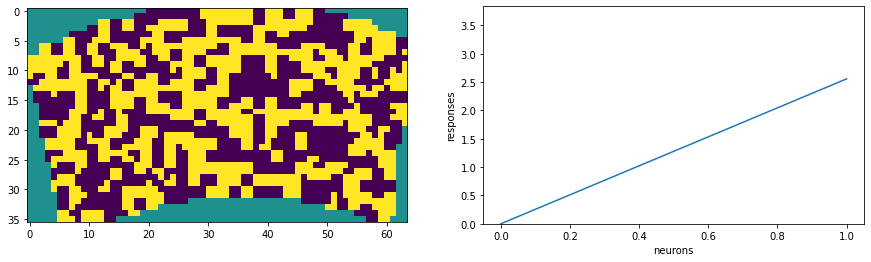

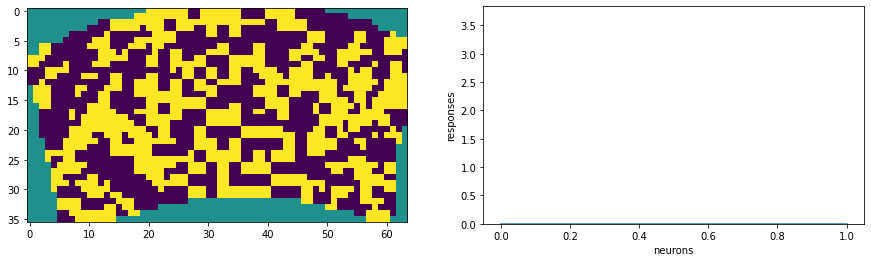

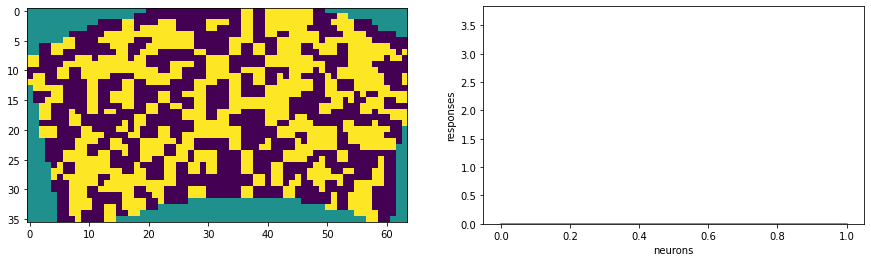

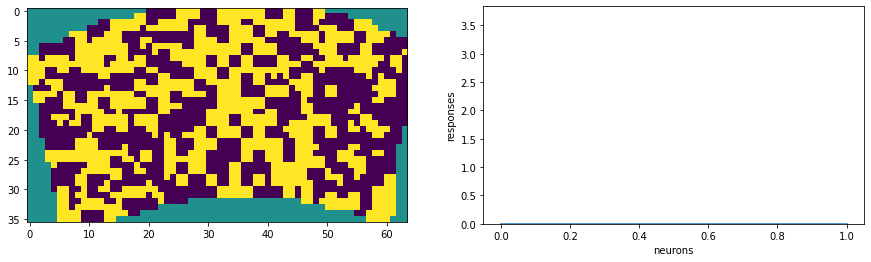

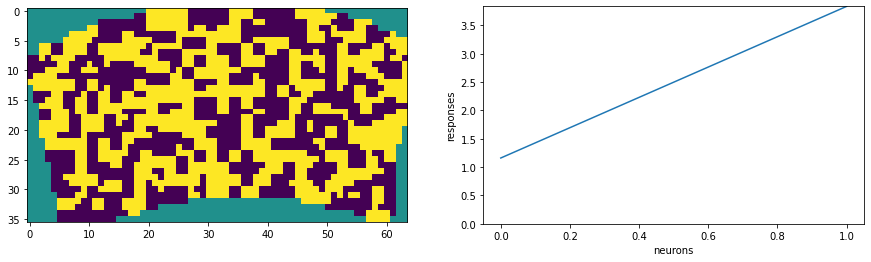

In [13]:
# show some example images and the neural responses
n_images = 5
max_response = responses[:n_images].max()

for i in range(n_images):
    fig, axs = plt.subplots(1, 2, figsize=(15,4))
    axs[0].imshow(images[i])
    axs[1].plot(responses[i])
    axs[1].set_xlabel('neurons')
    axs[1].set_ylabel('responses')
    axs[1].set_ylim([0, max_response])
    plt.show()

--------------------

# Grid search to tune model hyperparameters

In [14]:
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from lurz2020.models.models import se2d_fullgaussian2d
from lurz2020.training.trainers import standard_trainer as trainer
from lurz2020.utility.measures import get_correlations, get_fraction_oracles

#Define fucntions needed for bayes optimization

def grid_train_simple_CNN_(init_mu_range, init_sigma, gamma_input, gamma_readout):
    
    #Model config
    model_config={'hidden_channels': 64,
                'input_kern': 15,
                'hidden_kern': 13,
                'layers': 3,
                'init_mu_range': init_mu_range,
                'init_sigma': init_sigma,
                'gamma_input': gamma_input,
                'grid_mean_predictor': None,
                'gamma_readout': gamma_readout}

    #Change trainer config to not track and print the training progress
    trainer_config = {'track_training': False,
                  'detach_core': False}
    
    model = se2d_fullgaussian2d(**model_config,dataloaders=dataloaders_RGCs, seed=1)
    
    #Run training
    score, output, model_state = trainer(model=model, dataloaders=dataloaders_RGCs, seed=1, **trainer_config)
    
    #Get performance of model
    validation_correlation = get_correlations(model, dataloaders_RGCs["validation"], device='cuda', as_dict=False, per_neuron=False)
    
    return validation_correlation

# Bounded region of parameter space
pbounds={'init_mu_range': (0.1,1), 'init_sigma': (0.1,1), 'gamma_input': (0.5, 10), 'gamma_readout': (0.0050, 4)}

optimizer_simple_CNN = BayesianOptimization(
    f=grid_train_simple_CNN_,
    pbounds=pbounds,
    random_state=1,
    verbose = 1,
)

#Set location to save progress and results
logger = JSONLogger(path="./grid_search_simple_CNN_small_RFs_logs.json")
optimizer_simple_CNN.subscribe(Events.OPTIMIZATION_STEP, logger)

In [15]:
%%time
#Run optimization to maximize the target (corresponding to the correlation between the model predictions and the real responses for the validation set)
#init_points: number of random exploration points
#n_iter: number of exploitation points

optimizer_simple_CNN.maximize(init_points=7, n_iter=7)

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.58it/s]


[001|01/05] -/-> -0.015132983215153217


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.52it/s]


[002|02/05] -/-> -0.010993470437824726


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.61it/s]


[003|03/05] -/-> -0.00583037082105875


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.56it/s]


[004|04/05] -/-> -0.010434480383992195


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.57it/s]


[005|05/05] -/-> -0.013978632166981697


Epoch 6:   1%|▍                                                                        | 1/180 [00:00<00:19,  9.42it/s]

Restoring best model after lr decay! -0.013979 ---> -0.003303


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.63it/s]


[006|01/05] -/-> -0.014078810811042786


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.62it/s]


[007|02/05] -/-> -0.022999417036771774


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.62it/s]


[008|03/05] -/-> -0.026780594140291214


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.56it/s]


Epoch     9: reducing learning rate of group 0 to 1.5000e-03.
[009|04/05] -/-> -0.023423926904797554


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.66it/s]


[010|05/05] -/-> -0.02694319561123848


Epoch 11:   0%|                                                                                | 0/180 [00:00<?, ?it/s]

Restoring best model after lr decay! -0.026943 ---> -0.003303


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.62it/s]


[011|01/05] -/-> -0.019444413483142853


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.34it/s]


[012|01/05] ---> -0.0016864081844687462


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.47it/s]


[013|01/05] -/-> -0.01782413199543953


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.44it/s]


[014|02/05] -/-> -0.010074649937450886


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.40it/s]


[015|03/05] -/-> -0.005895780399441719


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.40it/s]


[016|03/05] ---> 0.002878075698390603


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.44it/s]


[017|01/05] -/-> -0.00606091134250164


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.41it/s]


[018|02/05] -/-> -0.017638757824897766


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.52it/s]


[019|03/05] -/-> -0.008015519939363003


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.42it/s]


[020|04/05] -/-> -0.0030312289018183947


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.47it/s]


[021|05/05] -/-> -0.009461317211389542
Restoring best model after lr decay! -0.009461 ---> 0.002878
Restoring best model! 0.002878 ---> 0.002878


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.49it/s]


[001|00/05] ---> 0.0016542896628379822


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.56it/s]


[002|01/05] -/-> -0.0028491849079728127


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.33it/s]


[003|02/05] -/-> -0.004399481229484081


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.42it/s]


[004|03/05] -/-> -0.0047973757609725


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.41it/s]


[005|03/05] ---> 0.002156026428565383


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.39it/s]


[006|00/05] ---> 0.011428382247686386


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.49it/s]


[007|01/05] -/-> -0.0035917581990361214


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.28it/s]


[008|02/05] -/-> -0.013891247101128101


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.19it/s]


[009|03/05] -/-> -0.01084168255329132


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.47it/s]


[010|04/05] -/-> -0.006387281231582165


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.45it/s]


[011|05/05] -/-> -0.016100475564599037


Epoch 12:   1%|▍                                                                       | 1/180 [00:00<00:31,  5.72it/s]

Restoring best model after lr decay! -0.016100 ---> 0.011428


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.51it/s]


Epoch    12: reducing learning rate of group 0 to 1.5000e-03.
[012|01/05] -/-> -0.0025881677865982056


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.69it/s]


[013|02/05] -/-> -0.01118185929954052


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.65it/s]


[014|03/05] -/-> -0.009674937464296818


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.56it/s]


[015|04/05] -/-> -0.008952239528298378


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.54it/s]


[016|05/05] -/-> -0.007265630178153515


Epoch 17:   1%|▍                                                                       | 1/180 [00:00<00:18,  9.50it/s]

Restoring best model after lr decay! -0.007266 ---> 0.011428


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.48it/s]


[017|01/05] -/-> -0.004116064868867397


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.59it/s]


Epoch    18: reducing learning rate of group 0 to 4.5000e-04.
[018|02/05] -/-> -0.004748942330479622


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.65it/s]


[019|03/05] -/-> -0.010996097698807716


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.51it/s]


[020|04/05] -/-> -0.009585014544427395


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.31it/s]


[021|05/05] -/-> -0.009677691385149956
Restoring best model after lr decay! -0.009678 ---> 0.011428
Restoring best model! 0.011428 ---> 0.011428


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.61it/s]


[001|00/05] ---> 0.013014965690672398


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.56it/s]


[002|00/05] ---> 0.03594348579645157


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.59it/s]


[003|01/05] -/-> -0.03241831064224243


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.61it/s]


[004|02/05] -/-> 0.006883995607495308


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.60it/s]


[005|03/05] -/-> -0.0027504432946443558


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.58it/s]


[006|04/05] -/-> -0.036811042577028275


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.42it/s]


[007|05/05] -/-> -0.035377442836761475


Epoch 8:   1%|▍                                                                        | 1/180 [00:00<00:19,  9.42it/s]

Restoring best model after lr decay! -0.035377 ---> 0.035943


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.39it/s]


[008|00/05] ---> 0.03745487332344055


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.50it/s]


[009|01/05] -/-> 0.005812319926917553


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.56it/s]


[010|02/05] -/-> 0.03094722330570221


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.47it/s]


[011|03/05] -/-> -0.0014478638768196106


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.54it/s]


[012|04/05] -/-> 0.023343415930867195


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.38it/s]


[013|05/05] -/-> 0.0037657050415873528


Epoch 14:   0%|                                                                                | 0/180 [00:00<?, ?it/s]

Restoring best model after lr decay! 0.003766 ---> 0.037455


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.39it/s]


Epoch    14: reducing learning rate of group 0 to 1.5000e-03.
[014|01/05] -/-> 0.0005928538739681244


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.45it/s]


[015|02/05] -/-> 0.004222585819661617


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.51it/s]


[016|03/05] -/-> 0.007596598006784916


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.58it/s]


[017|04/05] -/-> 0.021075360476970673


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.47it/s]


[018|05/05] -/-> -0.005164690315723419
Restoring best model after lr decay! -0.005165 ---> 0.037455
Restoring best model! 0.037455 ---> 0.037455


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.57it/s]


[001|00/05] ---> 0.007346583064645529


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.67it/s]


[002|00/05] ---> 0.013904755935072899


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.67it/s]


[003|00/05] ---> 0.022719692438840866


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.46it/s]


[004|01/05] -/-> -0.002095219912007451


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.75it/s]


[005|02/05] -/-> 0.016434812918305397


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.82it/s]


[006|03/05] -/-> 0.005330060143023729


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.94it/s]


[007|04/05] -/-> -0.009259143844246864


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.81it/s]


[008|05/05] -/-> 0.0032631326466798782


Epoch 9:   1%|▊                                                                        | 2/180 [00:00<00:17, 10.16it/s]

Restoring best model after lr decay! 0.003263 ---> 0.022720


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.74it/s]


Epoch     9: reducing learning rate of group 0 to 1.5000e-03.
[009|01/05] -/-> -0.027794938534498215


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.93it/s]


[010|02/05] -/-> -0.016179023310542107


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.77it/s]


[011|03/05] -/-> -0.013747042044997215


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.86it/s]


[012|04/05] -/-> -0.0163222998380661


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.79it/s]


[013|05/05] -/-> -0.02193344570696354


Epoch 14:   1%|▍                                                                       | 1/180 [00:00<00:18,  9.70it/s]

Restoring best model after lr decay! -0.021933 ---> 0.022720


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.81it/s]


[014|01/05] -/-> 0.008888672105967999


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.90it/s]


Epoch    15: reducing learning rate of group 0 to 4.5000e-04.
[015|02/05] -/-> -0.003622249700129032


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.53it/s]


[016|03/05] -/-> -0.007992211729288101


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.67it/s]


[017|04/05] -/-> -0.011919626034796238


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.59it/s]


[018|05/05] -/-> -0.013576473109424114
Restoring best model after lr decay! -0.013576 ---> 0.022720
Restoring best model! 0.022720 ---> 0.022720


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.57it/s]


[001|00/05] ---> -0.011214264668524265


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.74it/s]


[002|01/05] -/-> -0.011647257022559643


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.65it/s]


[003|01/05] ---> -0.010453456081449986


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.54it/s]


[004|00/05] ---> -0.008987891487777233


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.68it/s]


[005|01/05] -/-> -0.012476887553930283


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.56it/s]


[006|02/05] -/-> -0.012839234434068203


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.70it/s]


[007|03/05] -/-> -0.011961057782173157


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.73it/s]


[008|04/05] -/-> -0.014106310904026031


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.58it/s]


[009|05/05] -/-> -0.016454488039016724


Epoch 10:   1%|▍                                                                       | 1/180 [00:00<00:21,  8.33it/s]

Restoring best model after lr decay! -0.016454 ---> -0.008988


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.75it/s]


Epoch    10: reducing learning rate of group 0 to 1.5000e-03.
[010|01/05] -/-> -0.013530012220144272


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.61it/s]


[011|02/05] -/-> -0.01632310263812542


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.62it/s]


[012|03/05] -/-> -0.020843662321567535


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.74it/s]


[013|04/05] -/-> -0.019668688997626305


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.71it/s]


[014|05/05] -/-> -0.020549597218632698


Epoch 15:   1%|▍                                                                       | 1/180 [00:00<00:19,  9.35it/s]

Restoring best model after lr decay! -0.020550 ---> -0.008988


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.65it/s]


[015|01/05] -/-> -0.018604427576065063


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.54it/s]


Epoch    16: reducing learning rate of group 0 to 4.5000e-04.
[016|02/05] -/-> -0.01943582110106945


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.44it/s]


[017|03/05] -/-> -0.023262077942490578


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.50it/s]


[018|04/05] -/-> -0.02326272428035736


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.57it/s]


[019|05/05] -/-> -0.023640813305974007
Restoring best model after lr decay! -0.023641 ---> -0.008988
Restoring best model! -0.008988 ---> -0.008988


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.51it/s]


[001|01/05] -/-> 0.0020565930753946304


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.60it/s]


[002|02/05] -/-> -0.02367515116930008


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.60it/s]


[003|03/05] -/-> -0.0024068569764494896


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.63it/s]


[004|04/05] -/-> -0.014647062867879868


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.90it/s]


[005|05/05] -/-> -0.032059572637081146


Epoch 6:   1%|▍                                                                        | 1/180 [00:00<00:20,  8.55it/s]

Restoring best model after lr decay! -0.032060 ---> 0.004894


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.66it/s]


[006|00/05] ---> 0.012512139976024628


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.76it/s]


[007|01/05] -/-> 0.008994070813059807


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.79it/s]


[008|01/05] ---> 0.021916523575782776


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.84it/s]


[009|01/05] -/-> 0.017335182055830956


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.75it/s]


[010|02/05] -/-> 0.011138749308884144


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.85it/s]


[011|03/05] -/-> -0.0037174043245613575


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.83it/s]


[012|04/05] -/-> -0.0021353745833039284


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.88it/s]


[013|05/05] -/-> -0.0007376789581030607


Epoch 14:   1%|▊                                                                       | 2/180 [00:00<00:16, 10.77it/s]

Restoring best model after lr decay! -0.000738 ---> 0.021917


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.78it/s]


Epoch    14: reducing learning rate of group 0 to 1.5000e-03.
[014|01/05] -/-> 0.01032618060708046


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.75it/s]


[015|02/05] -/-> 0.01636025495827198


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.57it/s]


[016|03/05] -/-> 0.004910037387162447


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.79it/s]


[017|04/05] -/-> 0.007032458670437336


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.64it/s]


[018|05/05] -/-> 0.0035085882991552353
Restoring best model after lr decay! 0.003509 ---> 0.021917
Restoring best model! 0.021917 ---> 0.021917


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.41it/s]


[001|01/05] -/-> -0.030150964856147766


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.65it/s]


[002|02/05] -/-> -0.023267649114131927


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.52it/s]


[003|03/05] -/-> -0.010138984769582748


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.54it/s]


[004|04/05] -/-> -0.014587035402655602


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:19<00:00,  9.42it/s]


[005|05/05] -/-> -0.011848749592900276


Epoch 6:   1%|▍                                                                        | 1/180 [00:00<00:21,  8.40it/s]

Restoring best model after lr decay! -0.011849 ---> -0.007728


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.82it/s]


[006|00/05] ---> -0.007084941491484642


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.75it/s]


[007|01/05] -/-> -0.009048119187355042


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.78it/s]


[008|02/05] -/-> -0.008373069576919079


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.67it/s]


[009|03/05] -/-> -0.008995525538921356


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.83it/s]


[010|03/05] ---> -0.0063697053119540215


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.80it/s]


[011|01/05] -/-> -0.009393705986440182


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.73it/s]


[012|02/05] -/-> -0.008957323618233204


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.83it/s]


[013|02/05] ---> -0.006277711130678654


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.79it/s]


[014|01/05] -/-> -0.007069612853229046


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.81it/s]


[015|02/05] -/-> -0.008009483106434345


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.77it/s]


[016|02/05] ---> -0.005588985048234463


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.79it/s]


[017|01/05] -/-> -0.007192213553935289


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.79it/s]


[018|02/05] -/-> -0.008176430128514767


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.74it/s]


[019|02/05] ---> 0.0023832200095057487


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.74it/s]


[020|01/05] -/-> -0.007171429228037596


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████| 180/180 [00:18<00:00,  9.76it/s]


[021|02/05] -/-> -0.0005429163575172424


Epoch 22:  54%|██████████████████████████████████████▋                                | 98/180 [00:10<00:08,  9.60it/s]


KeyboardInterrupt: 

In [ ]:
#Best parameters combination
optimizer_simple_CNN.max

In [ ]:
#List of all parameters probed and their corresponding target values 
optimizer_simple_CNN.res

In [ ]:
gamma_input = []
gamma_readout = []
init_mu_range = []
init_sigma = []
target = []
for i in range(len(optimizer_simple_CNN.res)):
    target.append(optimizer_simple_CNN.res[i]['target'])
    init_mu_range.append(optimizer_simple_CNN.res[i]['params']['init_mu_range'])
    init_sigma.append(optimizer_simple_CNN.res[i]['params']['init_sigma'])
    gamma_readout.append(optimizer_simple_CNN.res[i]['params']['gamma_readout'])
    gamma_input.append(optimizer_simple_CNN.res[i]['params']['gamma_input'])
    
dict_plot = {'gamma_input': gamma_input,
            'gamma_readout': gamma_readout,
            'init_sigma': init_sigma,
            'init_mu_range': init_mu_range,
            'target':  target}

In [ ]:
import pandas as pd
import plotly.express as px

df_gs_results = pd.DataFrame(data=dict_plot)

#Plot evolution of bayesian grid search

fig = px.parallel_coordinates(df_gs_results, color='target', color_continuous_scale = 'portland', title= f"Bayes Hyperparameters Grid Search - Three layer CNN model for small RFs n={len(optimizer_simple_CNN.res)}")
fig.show()

# Build the best model, train core and readout and evaluate performance - 4 instances

Get 4 instances of the model for MEI generation:

In [10]:
%%time 
%%memit
from lurz2020.models.models import se2d_fullgaussian2d
from lurz2020.training.trainers import standard_trainer as trainer
from lurz2020.utility.measures import get_correlations, get_fraction_oracles, get_FEV

#Directory to sava models after training
path_models = join(path_dataset[0], 'models')
os.makedirs(path_models) 
#Models name 
models_name = 'tunned_model_'
#Generate 4 instances of the same model with different seeds, for MEI generation
n_seeds = 4
#Model config
model_config_tunned = {'init_mu_range': 0.1,
                'init_sigma': 0.64,
                'input_kern': 15,
                'hidden_kern': 13,
                'gamma_input': 1.0,
                'grid_mean_predictor': None,
                'gamma_readout': 0.99}
#Change trainer config to not track and print the training progress
trainer_config = {'track_training': False,
                  'verbose': None,
                  'detach_core': False}
#Save information of the training stage
comment = "Comment: Results." 
date = "Date: " + datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
stim = "Stimuli dataset: " + dataset_name
model_config = "Model configuration: " + str(model_config_tunned)
log_info = comment+'\n\n'+date+'\n'+ stim+'\n'+model_config+'\n'

save_training_log(log_info, models_name, path_models)
    
#Initialize variables for loop
models = []
train_correlation_models = []
validation_correlation_models = []
test_correlation_models = []
fraction_oracle = []
exp_var_models = []
model_state_before = [] 
model_state_after = []
for i in range(n_seeds): 

    model = se2d_fullgaussian2d(**model_config_tunned, dataloaders=dataloaders, seed=i)
    
    #Load the weights of the transfer core 
    model_state_before.append(model.state_dict())
    
    #Run training
    score, output, model_state = trainer(model=model, dataloaders=dataloaders, seed=1, **trainer_config)
    model_state_after.append(model.state_dict())
    
    #Get performance of model
    train_correlation_models.append(get_correlations(model, dataloaders["train"], device='cuda', as_dict=False, per_neuron=False))
    validation_correlation_models.append(get_correlations(model, dataloaders["validation"], device='cuda', as_dict=False, per_neuron=False))
    test_correlation_models.append(get_correlations(model, dataloaders["test"], device='cuda', as_dict=False, per_neuron=False))
    
    oracle_dataloader = static_loaders(**dataset_config, return_test_sampler=True, tier='test')
    fraction_oracle.append(get_fraction_oracles(model=model, dataloaders=oracle_dataloader, device='cuda')[0])

    instance_results = '\n ----------------------------------------- \n \
    Model instance #{0:1d} \n \
    Correlation (train set):      {1:.3f} \n \
    Correlation (validation set): {2:.3f} \n \
    Correlation (test set):       {3:.3f} \n \
    ----------------------------------------- \n \
    Fraction oracle (test set):   {4:.3f} \n'.format(i, train_correlation_models[i], validation_correlation_models[i],
                                        test_correlation_models[i], fraction_oracle[i])
    
   #Print and save instance training data on train log file
    print(instance_results)
    log_info = "\n Model instances training results: \n"+ instance_results
    save_training_log(log_info, models_name, path_models)
        
    #Save model state for loading later
    models.append(model)
    torch.save(model_state, join(path_models,models_name+str(i)+'.pth'))

Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 13.86it/s]


[001|00/05] ---> 0.014677395112812519


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.05it/s]


[002|01/05] -/-> 0.009899330325424671


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.00it/s]


[003|02/05] -/-> -0.016118470579385757


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:13<00:00, 13.78it/s]


[004|03/05] -/-> 0.0048835389316082


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 13.93it/s]


[005|04/05] -/-> 0.01193621102720499


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 13.97it/s]


[006|05/05] -/-> 0.0025054397992789745


Epoch 7:   1%|▌                                                                                                      | 1/180 [00:00<00:28,  6.25it/s]

Restoring best model after lr decay! 0.002505 ---> 0.014677


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 13.94it/s]


[007|01/05] -/-> -0.0038425964303314686


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.05it/s]


[008|02/05] -/-> 0.0015508411452174187


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 13.94it/s]


[009|03/05] -/-> -0.006185735575854778


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.11it/s]


[010|03/05] ---> 0.018142566084861755


Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.03it/s]


[011|01/05] -/-> -0.007523412350565195


Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.13it/s]


[012|02/05] -/-> -0.01900695078074932


Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.15it/s]


[013|03/05] -/-> 0.006645426154136658


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.10it/s]


[014|04/05] -/-> 0.010818695649504662


Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.35it/s]


[015|05/05] -/-> -0.005236716940999031


Epoch 16:   1%|▌                                                                                                     | 1/180 [00:00<00:28,  6.20it/s]

Restoring best model after lr decay! -0.005237 ---> 0.018143


Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.27it/s]


[016|01/05] -/-> -0.0022003743797540665


Epoch 17: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.31it/s]


[017|02/05] -/-> -0.016086552292108536


Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.28it/s]


[018|03/05] -/-> -0.01614191010594368


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.33it/s]


[019|04/05] -/-> -0.013849067501723766


Epoch 20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.32it/s]


[020|05/05] -/-> -0.007927315309643745
Restoring best model after lr decay! -0.007927 ---> 0.018143
Restoring best model! 0.018143 ---> 0.018143

 ----------------------------------------- 
     Model instance #0 
     Correlation (train set):      -0.001 
     Correlation (validation set): 0.018 
     Correlation (test set):       -0.012 
     ----------------------------------------- 



Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.30it/s]


[001|00/05] ---> 0.03759991377592087


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.26it/s]


[002|01/05] -/-> 0.0035397489555180073


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.35it/s]


[003|02/05] -/-> 0.023873262107372284


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.28it/s]


[004|03/05] -/-> -0.005102484952658415


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.27it/s]


[005|04/05] -/-> -0.0002957674441859126


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.35it/s]


[006|05/05] -/-> 0.0071196542121469975


Epoch 7:   1%|▌                                                                                                      | 1/180 [00:00<00:30,  5.86it/s]

Restoring best model after lr decay! 0.007120 ---> 0.037600


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.22it/s]


[007|01/05] -/-> 0.01354939304292202


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.36it/s]


[008|02/05] -/-> 0.024553801864385605


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.20it/s]


[009|03/05] -/-> 0.00836681667715311


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.32it/s]


[010|04/05] -/-> -0.03122084215283394


Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.35it/s]


[011|05/05] -/-> -0.0091174291446805


Epoch 12:   1%|▌                                                                                                     | 1/180 [00:00<00:28,  6.27it/s]

Restoring best model after lr decay! -0.009117 ---> 0.037600


Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.28it/s]


[012|01/05] -/-> 0.025540413334965706


Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.37it/s]


[013|02/05] -/-> 0.005973932798951864


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.22it/s]


[014|03/05] -/-> 0.006621928885579109


Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.38it/s]


[015|04/05] -/-> 0.007030718959867954


Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.34it/s]


[016|05/05] -/-> 0.003509465605020523
Restoring best model after lr decay! 0.003509 ---> 0.037600
Restoring best model! 0.037600 ---> 0.037600

 ----------------------------------------- 
     Model instance #1 
     Correlation (train set):      0.012 
     Correlation (validation set): 0.038 
     Correlation (test set):       0.013 
     ----------------------------------------- 



Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.31it/s]


[001|00/05] ---> 0.019501205533742905


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.31it/s]


[002|01/05] -/-> -0.02042555995285511


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.39it/s]


[003|02/05] -/-> -0.012872379273176193


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.30it/s]


[004|03/05] -/-> 0.005665745586156845


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.34it/s]


[005|04/05] -/-> 0.007708018645644188


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.37it/s]


[006|04/05] ---> 0.0196108166128397


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.25it/s]


[007|01/05] -/-> -0.002977297641336918


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.35it/s]


[008|02/05] -/-> -0.016559844836592674


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.24it/s]


[009|03/05] -/-> 0.012584513053297997


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.33it/s]


[010|04/05] -/-> 0.003709972370415926


Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.39it/s]


[011|05/05] -/-> 0.01853761449456215


Epoch 12:   1%|▌                                                                                                     | 1/180 [00:00<00:28,  6.26it/s]

Restoring best model after lr decay! 0.018538 ---> 0.019611


Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.29it/s]


[012|01/05] -/-> 0.005460703279823065


Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.28it/s]


[013|02/05] -/-> -0.002985547063872218


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.30it/s]


[014|03/05] -/-> 0.008387679234147072


Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.31it/s]


[015|04/05] -/-> 0.011874416843056679


Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.27it/s]


[016|05/05] -/-> 0.009800901636481285


Epoch 17:   1%|█▏                                                                                                    | 2/180 [00:00<00:12, 14.49it/s]

Restoring best model after lr decay! 0.009801 ---> 0.019611


Epoch 17: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.35it/s]


[017|00/05] ---> 0.024938484653830528


Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.24it/s]


[018|01/05] -/-> -0.003935022279620171


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.40it/s]


[019|02/05] -/-> 0.001795204821974039


Epoch 20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.29it/s]


[020|03/05] -/-> 0.01052052527666092


Epoch 21: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.18it/s]


[021|04/05] -/-> 0.008324222639203072


Epoch 22: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.33it/s]


[022|04/05] ---> 0.025549286976456642


Epoch 23: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.25it/s]


[023|01/05] -/-> 0.004513012245297432


Epoch 24: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.34it/s]


[024|02/05] -/-> 0.0010242080315947533


Epoch 25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.35it/s]


[025|03/05] -/-> -0.002054163720458746


Epoch 26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.26it/s]


[026|04/05] -/-> -0.0005310052074491978


Epoch 27: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.42it/s]


[027|05/05] -/-> 0.01659335568547249
Restoring best model after lr decay! 0.016593 ---> 0.025549
Restoring best model! 0.025549 ---> 0.025549

 ----------------------------------------- 
     Model instance #2 
     Correlation (train set):      0.007 
     Correlation (validation set): 0.026 
     Correlation (test set):       0.003 
     ----------------------------------------- 



Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.27it/s]


[001|00/05] ---> 0.002347912872210145


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.27it/s]


[002|01/05] -/-> -0.001173080294393003


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.38it/s]


[003|02/05] -/-> -0.01124679297208786


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.32it/s]


[004|03/05] -/-> -0.01676325313746929


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.22it/s]


[005|04/05] -/-> -0.005435122177004814


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.36it/s]


[006|04/05] ---> 0.01705298200249672


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.24it/s]


[007|01/05] -/-> 0.012860331684350967


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.30it/s]


[008|02/05] -/-> -0.006141250021755695


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.34it/s]


[009|03/05] -/-> -0.012054776772856712


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.25it/s]


[010|04/05] -/-> -0.009956039488315582


Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.36it/s]


[011|04/05] ---> 0.04797348380088806


Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.24it/s]


[012|01/05] -/-> 0.022163202986121178


Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.44it/s]


[013|02/05] -/-> -0.013571013696491718


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.16it/s]


[014|03/05] -/-> 0.0038132998161017895


Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.32it/s]


[015|04/05] -/-> -0.009649659506976604


Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.32it/s]


[016|05/05] -/-> -0.0065394118428230286


Epoch 17:   1%|▌                                                                                                     | 1/180 [00:00<00:29,  6.00it/s]

Restoring best model after lr decay! -0.006539 ---> 0.047973


Epoch 17: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.30it/s]


[017|01/05] -/-> -0.029315464198589325


Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.37it/s]


[018|02/05] -/-> 0.0007857955060899258


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.25it/s]


[019|03/05] -/-> -0.0017900039674714208


Epoch 20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.36it/s]


[020|04/05] -/-> 0.0027409493923187256


Epoch 21: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.32it/s]


[021|05/05] -/-> -0.005701793357729912


Epoch 22:   1%|█▏                                                                                                    | 2/180 [00:00<00:12, 14.72it/s]

Restoring best model after lr decay! -0.005702 ---> 0.047973


Epoch 22: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.27it/s]


[022|01/05] -/-> -0.017430342733860016


Epoch 23: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.36it/s]


[023|02/05] -/-> 0.03567918762564659


Epoch 24: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.28it/s]


[024|03/05] -/-> 0.016991930082440376


Epoch 25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 13.91it/s]


[025|04/05] -/-> 0.006581359077244997


Epoch 26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:12<00:00, 14.22it/s]


[026|05/05] -/-> -0.002691887319087982
Restoring best model after lr decay! -0.002692 ---> 0.047973
Restoring best model! 0.047973 ---> 0.047973

 ----------------------------------------- 
     Model instance #3 
     Correlation (train set):      0.033 
     Correlation (validation set): 0.048 
     Correlation (test set):       0.024 
     ----------------------------------------- 

peak memory: 2217.51 MiB, increment: 105.14 MiB
Wall time: 23min 42s


In [11]:
#Print results of after training step
results = "\n Results for " + models_name + " model: \n \
    ----------------------------------------- \n \
    {0:1d} instances of the model trained \n \
    Mean correlation (train set):      {1:.3f} \n \
    Mean correlation (validation set): {2:.3f} \n \
    Mean correlation (test set):       {3:.3f} \n \
    ----------------------------------------- \n \
    Mean fraction oracle (test set):   {4:.3f} \n".format(
    len(train_correlation_models), np.mean(train_correlation_models), np.mean(validation_correlation_models), 
    np.mean(test_correlation_models), np.mean(fraction_oracle))
    
#Print and save average performance results on train log file
print(results)
log_info = results
save_training_log(log_info, models_name, path_models)


 Results for fullgaussian tunned model: 
     ----------------------------------------- 
     4 instances of the model trained 
     Mean correlation (train set):      0.013 
     Mean correlation (validation set): 0.032 
     Mean correlation (test set):       0.007 
     ----------------------------------------- 
     


### Predict neural responses to an image (here from the train set)

In [ ]:
# show some example images and the neural responses
n_images = 10
max_response = responses[:n_images].max()

for i in range(n_images):
    input_image = images[i]
    fig, axs = plt.subplots(1, 6, figsize=(20,4))
    axs[0].imshow(input_image)
    axs[1].plot(responses[i])
    axs[1].set_title('real responses')
    
    for n in range(len(models)):

        predicted_response = models[n](torch.from_numpy(input_image).view(1,1,input_image.shape[0],input_image.shape[1]).cuda())
        predicted_response = predicted_response.squeeze().cpu().data.numpy()
        axs[n+2].plot(predicted_response)
        axs[n+2].set_xlabel('neurons')
        axs[n+2].set_title('predicted responses model '+str(n))
  

    plt.tight_layout()
    plt.show()

--------------------------------

In [ ]:
torch.cuda.empty_cache()